# Lecture 5: Calorimeters

## EM showers and electromagnetic calorimeter concept

Author: Aleksander Filip Żarnecki (University of Warsaw)

### Import libraries 

In [1]:
import math
from ROOT import *
import numpy as np

# For inline image display
from IPython.display import Image

Welcome to JupyROOT 6.24/04


### ROOT style configurationb

In [2]:
# Set ROOT graphics options

gROOT.SetStyle("Plain")

# Default canvas  size

gStyle.SetCanvasDefW(600)
gStyle.SetCanvasDefH(400)
 
# set the margins
  
gStyle.SetPadBottomMargin(0.18)
gStyle.SetPadTopMargin(0.08)
gStyle.SetPadRightMargin(0.08)
gStyle.SetPadLeftMargin(0.17)

# set the number of divisions to show

gStyle.SetNdivisions(510, "xy")

# show grid

gStyle.SetPadGridX(1)
gStyle.SetPadGridY(1)

# border ploted only around statistics

gStyle.SetPadBorderMode(0)
gStyle.SetFrameBorderMode(0)
gStyle.SetLegendBorderSize(0)
gStyle.SetTitleBorderSize(0)
gStyle.SetStatBorderSize(1)

# Text sizes

gStyle.SetTextSize(0.05)
gStyle.SetTitleSize(0.06,"xyz")
gStyle.SetLabelSize(0.05,"xyz")

gStyle.SetLabelOffset(0.015,"xyz")
gStyle.SetTitleOffset(1.2,"yz")
gStyle.SetTitleOffset(1.0,"x")

# Font settings

font = 42
gStyle.SetTitleFont(font)
gStyle.SetTitleFontSize(0.05)
gStyle.SetStatFont(font)
gStyle.SetStatFontSize(0.06)
gStyle.SetTextFont(font)
gStyle.SetLabelFont(font,"xyz")
gStyle.SetTitleFont(font,"xyz")
gStyle.SetLegendFont(font)

# Line settings

gStyle.SetHistLineWidth(2)
gStyle.SetFrameLineWidth(2)
gStyle.SetFuncWidth(2)
gStyle.SetHistLineColor(kBlue)
gStyle.SetFuncColor(kRed)

# Log scale
gStyle.SetOptLogy(0)

# Histogram title
gStyle.SetOptTitle(1)  

# Histogram statistics
gStyle.SetOptStat(1100)

# Fit results
gStyle.SetOptFit(0) 


### Part I: definition of EM shower class

* Single shower particle class

In [3]:
# Class for single shower particle

class shParticle:
    'Particle of the EM shower (in 1D)'
    E = 0.0
    q = 0
    xmin = 0.0
    xmax = 0.0
    
    def __init__(self,E,q,xmin):
        self.E = E
        self.q = q
        self.xmin = xmin
        self.xmax = xmin
        
    def __str__(self):
        if self.xmin == self.xmax :
            return 'E = %g   q = % g    created at X = %g [X0]' % (self.E, self.q, self.xmin)
        else :
            return 'E = %g   q = % g    propagated from X = %g to %g  [X0]' % (self.E, self.q, self.xmin, self.xmax)
        
    def setlen(self,shlen):
        self.xmax = self.xmin + shlen
 
    def getlen(self):
        return self.xmax - self.xmin
    
    def getsamp(self,dX):
        i1 = int(self.xmin/dX)
        i2 = int(self.xmax/dX)
        return i2-i1


In [4]:
# Test of the particle class

x = shParticle(10.,-1.,0.)
print(x)
x.setlen(1.2)
print(x)

E = 10   q = -1    created at X = 0 [X0]
E = 10   q = -1    propagated from X = 0 to 1.2  [X0]


* Electromagnetic shower class

(list of shower particles + few counters)

In [5]:
# EM shower class

class emShower:
    'Model of EM shower development'

    def __init__(self,E0,q0,x0):
        # initialize with input particle
        self.shower = []
        self.shower.append(shParticle(E0,q0,x0))
        # only propagated particles are counted
        # so set counters to zero at that point
        self.npar = 0  
        self.nch = 0
        self.chlen = 0.0
        self.eloss = 0.0

    def __str__(self):
        return 'Shower with %d particles, %d charged, total track lenght %g X0, energy loss %g GeV' % (self.npar, self.nch, self.chlen, self.eloss)
    
    def develope(self,Ec,dEdx=0.0):
        # consider increasing number of particles in the shower
        for par in self.shower :
            # conversion/radiation length [X0]
            if par.q == 0 :
                intlen = 9.0/7.0
            else :
                intlen = 1.0
               
            # generate conversion/radiation point
            
            shlen = np.random.exponential(intlen)
            
            # check energy loss of particle
            
            elen = 0
            
            if par.q != 0 and dEdx > 0 :
                elen = shlen * dEdx
                if elen > par.E :
                    shlen = par.E/dEdx
                    elen = par.E
            
            # propagate particle to this point
            
            par.setlen(shlen)
            self.npar+=1
            if par.q != 0 :
                self.nch+=1
                self.chlen+=shlen
                self.eloss+=elen

            # Energy at the final point
            
            Eleft = par.E - elen
            
            # Final point - origin for new particles
            
            xnew = par.xmax 
           
            # If above critical energy:
            #   convert gamma to two photons or radiate photon
            if Eleft > Ec :
                E1 = Eleft * np.random.random(1)    #  Very siplified energy splitting
                E2 = Eleft - E1
                if par.q == 0 :
                    self.shower.append(shParticle(E1,+1,xnew))
                    self.shower.append(shParticle(E2,-1,xnew))
                else:
                    self.shower.append(shParticle(E1,par.q,xnew))
                    self.shower.append(shParticle(E2,0,xnew))
                    
    def sample(self,Xsamp):
        nsamp = 0
        for par in self.shower:
            if par.q != 0 :
                nsamp += par.getsamp(Xsamp)
        return nsamp

    def profile(self,Nbin,Xmax):
        hprof = TH1D("hprof","Shower profile",Nbin, 0, Xmax)
        hprof.GetXaxis().SetTitle("x [X0]")
        hprof.GetYaxis().SetTitle("Particles")
        dX=Xmax/Nbin
        for par in self.shower:
            if par.q != 0 :
                nx = par.getsamp(dX)
                for ix in range(nx):
                    hprof.Fill(par.xmin+ix*dX)
        return hprof
    
    def dump(self,Nprt):
        for iprt in range(len(self.shower)):
            print(self.shower[iprt])
            if iprt+1 == Nprt : break
  

In [6]:
# Test of shower class

testshower = emShower(0.1,0.,0.)  # 100 MeV photon at x = 0
print(testshower)                 # Shower not created yet!
print("Initial particle: ",testshower.shower[0],"\n")

# Generate EM shower from primary particle

testshower.develope(0.,0.1)  # No critical energy, high ionization losses (to reduce number of secondaries)

print(testshower)             # Final shower statistics 

# Test shower dump (all)

testshower.dump(-1)

Shower with 0 particles, 0 charged, total track lenght 0 X0, energy loss 0 GeV
Initial particle:  E = 0.1   q =  0    created at X = 0 [X0] 

Shower with 3 particles, 2 charged, total track lenght 1 X0, energy loss 0.1 GeV
E = 0.1   q =  0    propagated from X = 0 to 1.21274  [X0]
E = 0.0532004   q =  1    propagated from X = 1.21274 to 1.74474  [X0]
E = 0.0467996   q = -1    propagated from X = 1.21274 to 1.68073  [X0]


In [7]:
# Direct access to shower variables:

print('Shower with ',testshower.npar,' particles, ',testshower.nch,' charged particles')
print('Total length of charged particle tracks: %.3g X0 ' % float(testshower.chlen))
print('Total energy deposited in ionization: %.5g GeV ' % float(testshower.eloss))


Shower with  3  particles,  2  charged particles
Total length of charged particle tracks: 1 X0 
Total energy deposited in ionization: 0.1 GeV 


### Part II
### Shower simulation

In [8]:
# Properties of the absorber material (Copper)

# Critical energy [GeV] for Copper

Ec = 0.020

# Ionization losses [GeV/X0] for Copper (MIP)

dEdx = 0.018


In [9]:
#  Incident particle (5 GeV electron)

E0 = 5
q0 = -1

# Initialise shower with incident particle

myshower = emShower(E0,q0,0.)

print("Initial shower particle: ", myshower.shower[0])


# Execute shower development procedure (with Copper parameters)

myshower.develope(Ec,dEdx)

# Shower summary

print(myshower)

Initial shower particle:  E = 5   q = -1    created at X = 0 [X0]
Shower with 433 particles, 307 charged, total track lenght 213.917 X0, energy loss 3.85051 GeV


In [10]:
# Test shower dump (first 10 rows)

myshower.dump(10)


E = 5   q = -1    propagated from X = 0 to 2.23909  [X0]
E = 0.358499   q = -1    propagated from X = 2.23909 to 3.0714  [X0]
E = 4.6012   q =  0    propagated from X = 2.23909 to 3.15736  [X0]
E = 0.213823   q = -1    propagated from X = 3.0714 to 6.71597  [X0]
E = 0.129694   q =  0    propagated from X = 3.0714 to 8.75702  [X0]
E = 0.68681   q =  1    propagated from X = 3.15736 to 3.98991  [X0]
E = 3.91439   q = -1    propagated from X = 3.15736 to 4.18491  [X0]
E = 0.0963509   q = -1    propagated from X = 6.71597 to 7.07386  [X0]
E = 0.0518697   q =  0    propagated from X = 6.71597 to 6.87717  [X0]
E = 0.108475   q =  1    propagated from X = 8.75702 to 9.48056  [X0]


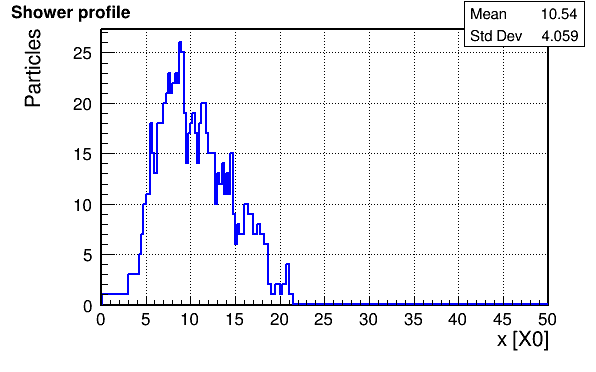

Info in <TCanvas::Print>: png file shprofile_5.png has been created


In [11]:
# Histogram of the longitudinal shower profile

Xmax = 50.
Nprof = 200

shprofile=myshower.profile(Nprof,Xmax)

csh = TCanvas('csh')

shprofile.DrawCopy()

csh.Update()

fname='shprofile_'+str(E0)+'.png'
csh.Print(fname)
Image(filename=fname)

### Part III
### Average cascade profile

In [12]:
#  Incident particle (5 GeV electron)

E0 = 5
q0 = -1

# Repeat shower simulation multiple times

Nmc = 1000
myshowers = []

for imc in range(Nmc):
    newshower = emShower(E0,q0,0.)
    newshower.develope(Ec,dEdx)
    myshowers.append(newshower)
    if (imc+1)%100 == 0:
        print(imc+1,' showers generated ',myshowers[imc].npar,' particles')

100  showers generated  447  particles
200  showers generated  447  particles
300  showers generated  431  particles
400  showers generated  475  particles
500  showers generated  399  particles
600  showers generated  423  particles
700  showers generated  413  particles
800  showers generated  447  particles
900  showers generated  453  particles
1000  showers generated  391  particles


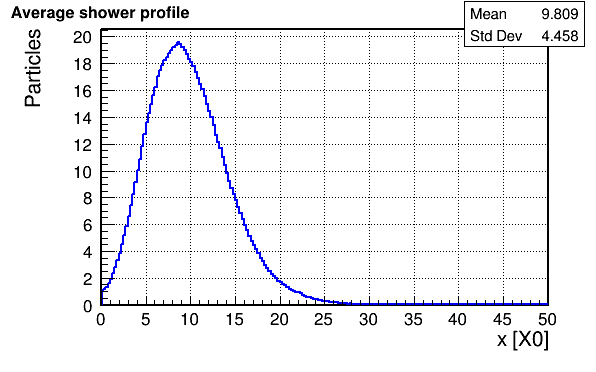

Info in <TCanvas::Print>: png file avprofile_5.png has been created


In [13]:
# Define empty histogram with the same binning (Nprof,Xmax) as before

avprofile=shprofile
avprofile.SetNameTitle("havprof","Average shower profile")
avprofile.Reset()

# Average generated showers

wmc = 1/Nmc

for newshower in myshowers:
    avprofile.Add(newshower.profile(Nprof,Xmax),wmc)

csh2 = TCanvas('csh2')
avprofile.DrawCopy()

csh2.Update()
fname = 'avprofile_'+str(E0)+'.png'
csh2.Print(fname)
Image(filename=fname)

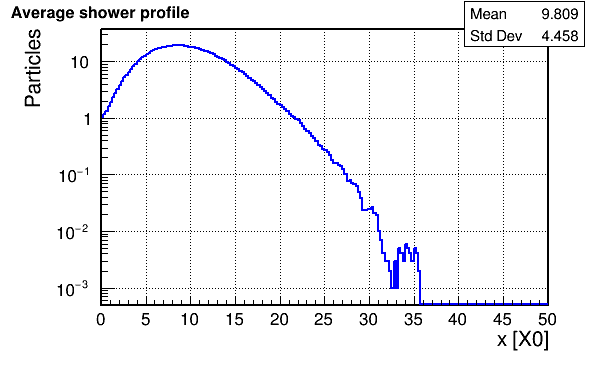

Info in <TCanvas::Print>: png file avprofile_5_log.png has been created


In [14]:
csh2.SetLogy(1)
csh2.Update()
fname = 'avprofile_'+str(E0)+'_log.png'
csh2.Print(fname)
Image(filename=fname)

### Part IV
### Uniform calorimeter response

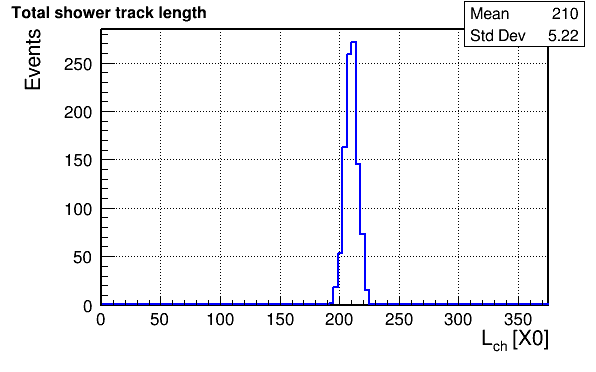

Info in <TCanvas::Print>: png file hchlen_5.png has been created


In [15]:
# Prepare response histograms

Nbin = 100

Lmax = 1.5*E0/Ec

hchlen = TH1D("hchlen","Total shower track length",Nbin, 0, Lmax)
hchlen.GetXaxis().SetTitle("L_{ch} [X0]")
hchlen.GetYaxis().SetTitle("Events")

# Scan simulated showers

dchlen = []
dchlen.clear()

for shower in myshowers:
    dchlen.append(shower.chlen)
    hchlen.Fill(shower.chlen)


clen = TCanvas('clen')

hchlen.DrawCopy()

clen.Update()

fname='hchlen_'+str(E0)+'.png'
clen.Print(fname)
Image(filename=fname)

In [16]:
# Estimate uniform calorimeter resolution

print('Uniform calorimeter model: %.3g%% energy resolution at %g GeV ' % (100*np.std(dchlen)/np.mean(dchlen),E0))

Uniform calorimeter model: 2.49% energy resolution at 5 GeV 


### Part V
### Sampling calorimeter response

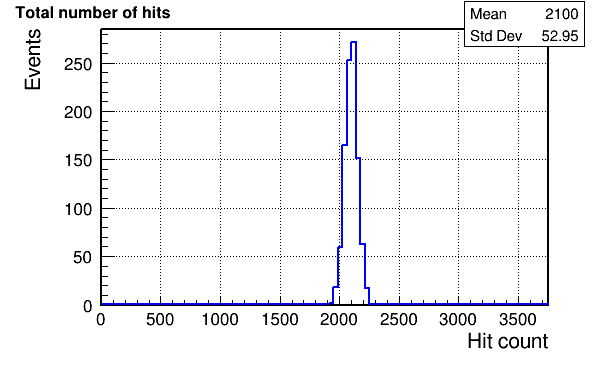

Warning in <TROOT::Append>: Replacing existing TH1: hchhit (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: chit
Info in <TCanvas::Print>: png file hchhit_5.png has been created


In [19]:
# Sampling distance [X0]

Xsamp = 0.1

# Prepare response histograms

Nbin = 100

Lmax = 1.5*E0/Ec
Nmax = Lmax/Xsamp

hchhit = TH1D("hchhit","Total number of hits",Nbin, 0, Nmax)
hchhit.GetXaxis().SetTitle("Hit count")
hchhit.GetYaxis().SetTitle("Events")

# Sample generated showers
dchhit = []
dchhit.clear()

for shower in myshowers:
    nsamp=shower.sample(Xsamp)
    dchhit.append(nsamp)
    hchhit.Fill(nsamp)

# Plot histogram

chit = TCanvas('chit')

hchhit.DrawCopy()

chit.Update()

fname = 'hchhit_'+str(E0)+'.png'
chit.Print(fname)
Image(filename=fname)

In [20]:
print('Sampling calorimeter model: %.3g%% resolution at %g GeV ' % (100*np.std(dchhit)/np.mean(dchhit),E0))

Sampling calorimeter model: 2.52% resolution at 5 GeV 
